In [5]:
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import RocCurveDisplay, auc, roc_auc_score
import lightgbm as lgb

In [6]:
results_folder = pathlib.Path("../../data/POC2_data/runs/")
grid_results = list(results_folder.glob("*/grid_cv.pkl"))
grid_results

[PosixPath('../../data/POC2_data/runs/128_dims_fixed_walks_30_epochs/grid_cv.pkl'),
 PosixPath('../../data/POC2_data/runs/64_dims_fixed_walks_30_epochs/grid_cv.pkl'),
 PosixPath('../../data/POC2_data/runs/64_dims_fixed_walks_50_epochs/grid_cv.pkl'),
 PosixPath('../../data/POC2_data/runs/64_dims_dynamic_walks_30_epochs/grid_cv.pkl')]

In [7]:
grid_objs = dict()

for grid_file in grid_results:
    run_name = grid_file.parent.name
    object = None
    with (open(grid_file, "rb")) as openfile:
        object = pickle.load(openfile)
    grid_objs[run_name] = object

In [8]:
grid_objs

{'128_dims_fixed_walks_30_epochs': GridSearchCV(estimator=LGBMClassifier(),
              param_grid={'boosting_type': ('gbdt', 'dart', 'goss'),
                          'learning_rate': (0.1, 0.05, 0.03, 0.01, 0.001),
                          'max_depth': (50, 100, 200, 300, -1),
                          'metric': ['auc'], 'n_estimators': (50, 100, 200, 300),
                          'num_leaves': (100, 150, 200), 'objective': ['binary'],
                          'random_state': [42]},
              verbose=3),
 '64_dims_fixed_walks_30_epochs': GridSearchCV(estimator=LGBMClassifier(),
              param_grid={'boosting_type': ('goss', 'gbdt', 'dart'),
                          'learning_rate': (0.1, 0.05, 0.03, 0.01, 0.001),
                          'max_depth': (50, 100, 200, 300, -1),
                          'metric': ['auc'], 'n_estimators': (50, 100, 200, 300),
                          'num_leaves': (100, 150, 200), 'objective': ['binary'],
                          'ran

In [9]:
scores = dict()
configs = dict()
for run_name, gs_cv in grid_objs.items():
    scores[run_name] = gs_cv.best_score_
    configs[run_name] = gs_cv.best_params_

In [10]:
scores

{'128_dims_fixed_walks_30_epochs': 0.575,
 '64_dims_fixed_walks_30_epochs': 0.5342185990338164,
 '64_dims_fixed_walks_50_epochs': 0.47272282608695654,
 '64_dims_dynamic_walks_30_epochs': 0.5333333333333334}

In [11]:
configs

{'128_dims_fixed_walks_30_epochs': {'boosting_type': 'dart',
  'learning_rate': 0.001,
  'max_depth': 50,
  'metric': 'auc',
  'n_estimators': 300,
  'num_leaves': 100,
  'objective': 'binary',
  'random_state': 42},
 '64_dims_fixed_walks_30_epochs': {'boosting_type': 'goss',
  'learning_rate': 0.1,
  'max_depth': 50,
  'metric': 'auc',
  'n_estimators': 100,
  'num_leaves': 100,
  'objective': 'binary',
  'random_state': 42},
 '64_dims_fixed_walks_50_epochs': {'boosting_type': 'goss',
  'learning_rate': 0.1,
  'max_depth': 50,
  'metric': 'auc',
  'n_estimators': 50,
  'num_leaves': 100,
  'objective': 'binary',
  'random_state': 42},
 '64_dims_dynamic_walks_30_epochs': {'boosting_type': 'goss',
  'learning_rate': 0.1,
  'max_depth': 50,
  'metric': 'auc',
  'n_estimators': 100,
  'num_leaves': 100,
  'objective': 'binary',
  'random_state': 42}}

In [12]:
results_df = pd.DataFrame()
results_df['config'] = list(configs.keys())
results_df['auc'] = list(scores.values())
results_df['params'] = list(configs.values())

In [13]:
results_df

,config,auc,params
0,128_dims_fixed_walks_30_epochs,0.575000,"{'boosting_type': 'dart', 'learning_rate': 0.0..."
1,64_dims_fixed_walks_30_epochs,0.534219,"{'boosting_type': 'goss', 'learning_rate': 0.1..."
2,64_dims_fixed_walks_50_epochs,0.472723,"{'boosting_type': 'goss', 'learning_rate': 0.1..."
3,64_dims_dynamic_walks_30_epochs,0.533333,"{'boosting_type': 'goss', 'learning_rate': 0.1..."


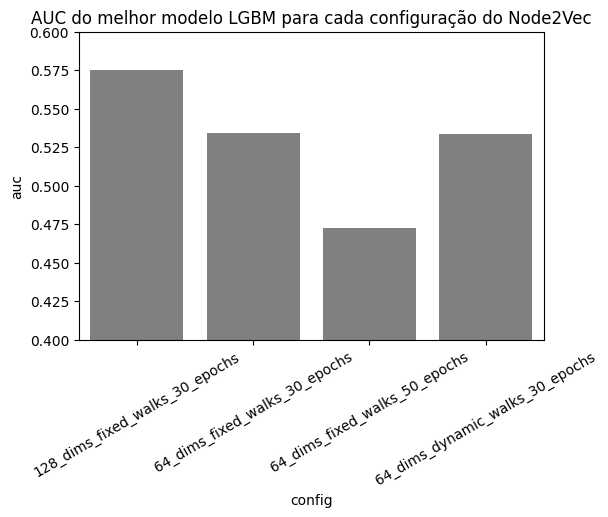

In [14]:
plt.figure(figsize=(6,4))
sns.barplot(data=results_df, x="config", y="auc", color="grey")
plt.xticks(rotation=30)
plt.ylim((0.4, 0.6))
plt.title("AUC do melhor modelo LGBM para cada configuração do Node2Vec")
plt.show()

In [15]:
embedds_files = list(pathlib.Path("../../data/POC2_data/graph_embeddings/node2vec/").glob("*/*/embs_*.npy") )
embedds_files

[PosixPath('../../data/POC2_data/graph_embeddings/node2vec/dynamic_walk_length/64/embs_64.npy'),
 PosixPath('../../data/POC2_data/graph_embeddings/node2vec/fixed_walks/128_dims/embs_128.npy'),
 PosixPath('../../data/POC2_data/graph_embeddings/node2vec/fixed_walks/64_dims_50_epochs/embs_64.npy'),
 PosixPath('../../data/POC2_data/graph_embeddings/node2vec/fixed_walks/64_dims/embs_64.npy')]

In [35]:
embeds_objs = dict()
embeds_names_to_files = dict()
for embd_file in embedds_files:
    file_path_str = str(embd_file)
    parts_of_interest = file_path_str.split(".npy")[0].split("/")[-3:]
    print(parts_of_interest)
    dynamic = parts_of_interest[0].startswith("dynamic")
    dims = 64 if parts_of_interest[1].startswith("64") else 128
    epochs = 50 if "50" in parts_of_interest[1] else 30
    name = str(dims)+"_dims_"
    name += "dynamic" if dynamic else "fixed"
    name += "_walks_"
    name += str(epochs)+"_epochs"
    embeds_objs[name] = np.load(embd_file)
    embeds_names_to_files[name] = file_path_str

['dynamic_walk_length', '64', 'embs_64']
['fixed_walks', '128_dims', 'embs_128']
['fixed_walks', '64_dims_50_epochs', 'embs_64']
['fixed_walks', '64_dims', 'embs_64']


In [36]:
embeds_objs.keys()

dict_keys(['64_dims_dynamic_walks_30_epochs', '128_dims_fixed_walks_30_epochs', '64_dims_fixed_walks_50_epochs', '64_dims_fixed_walks_30_epochs'])

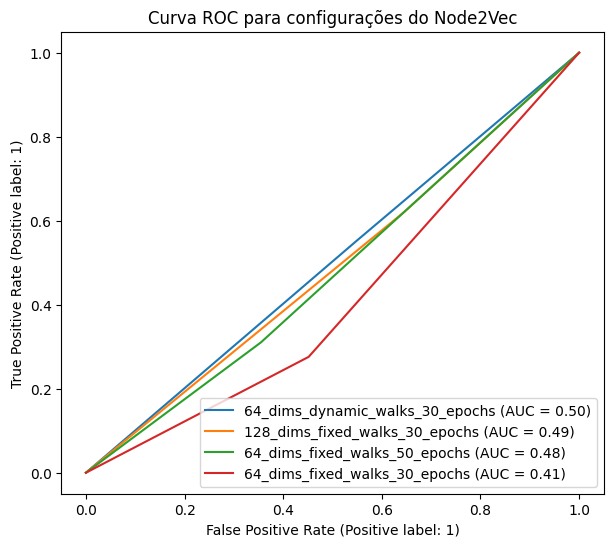

In [48]:
random_state = 42
axs = None
aucs = dict()
for config, embeds_npy in embeds_objs.items():
    num_instances = embeds_npy.shape[0]
    y = [1]*(num_instances//2) + [0]*(num_instances//2)

    X_train, X_test, y_train, y_test = train_test_split(embeds_npy, y, 
                                                        test_size=0.2,
                                                        random_state=random_state)
    # d_train = lgb.Dataset(X_train, label=y_train)
    # lgb_model = lgb.LGBMClassifier(**configs[name])
    # lgb_model.fit(X_train, y_train)
    lgb_model = grid_objs[config]

    y_pred = lgb_model.predict(X_test)

    # for i in range(X_test.shape[0]):
    #     if y_pred[i]>= 0.5:
    #         y_pred[i] = 1
    #     else:
    #         y_pred[i] = 0

    aucs[config] = roc_auc_score(y_test, y_pred)
    if axs is None:
        fig, ax = plt.subplots(figsize=(7,6))
        # disp = RocCurveDisplay.from_estimator(lgb_model, X_test, y_test, name=config)
        disp = RocCurveDisplay.from_predictions(y_test, y_pred, name=config, ax=ax)
        axs = disp.ax_
    else:
        # disp = RocCurveDisplay.from_estimator(lgb_model, X_test, y_test, ax=axs, name=config)
        disp = RocCurveDisplay.from_predictions(y_test, y_pred, name=config, ax=axs)

plt.title("Curva ROC para configurações do Node2Vec")
plt.show()

In [136]:
aucs

{'64_dims_dynamic_walks': 0.5016685205784205,
 '128_dims_fixed_walks': 0.4877641824249166,
 '64_dims_fixed_walks': 0.4121245828698554}

In [137]:
auc()

TypeError: auc() missing 2 required positional arguments: 'x' and 'y'